# ROI tracking across days

[Run and save across-day alignment](#Run-and-save-alignment)  \
[Collect tracked cells](#Collect-and-plot-fraction-of-tracked-cells-over-various-day-combos)

In [1]:
# import
import os
import dill
import numpy as np

import TwoPUtils as tpu

import reward_relative as rrel
from reward_relative import sessions_dict
import reward_relative.utilities as ut
from reward_relative import multiDayROIAlign as roiAlign

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# Change this to your path dict file
# If you don't have a path dict file, see reward_relative.path_dict_example and create one
from reward_relative.path_dict_firebird import path_dictionary as path_dict

In [3]:
path_dict

{'preprocessed_root': '/data/2P',
 'sbx_root': '/mnt/oak/InVivoDA/2P_Data',
 'gdrive_root': '/mnt/gdrive/2P_Data',
 'VR_Data': '/data/2P/VR_Data',
 'git_repo_root': '/home/mari/local_repos/2p_repos',
 'TwoPUtils': '/home/mari/local_repos/2p_repos/TwoPUtils',
 'home': '/home/mari',
 'fig_dir': '/data/2P/fig_scratch'}

In [4]:
base_pkl_path = os.path.join(path_dict['preprocessed_root'],"sess")

## Run and save alignment

For single/multiple mice, using sessions dict

Saves the ROI matches between pairs of days as roi_aligner_results.pkl in `path_dict['preprocessed_root']/sess/<mouse>/`

In [5]:
# Specify mice to run
anim_list = ['GCAMP17', 'GCAMP18', 'GCAMP19']

# Check dictionary indices of experiment days you want to run
# Alternatively, you can pass the whole sessions dict per mouse 
#     to roiAlign.single_mouse_alignerif you want to run every session
exp_days = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

for mouse in anim_list:
    sess_inds = []
    if mouse in sessions_dict.single_plane.keys(): # for some reason multiplane animals are also being included in single plane dict
        use_dict = sessions_dict.single_plane
    elif mouse in sessions_dict.multi_plane.keys():
        use_dict = sessions_dict.multi_plane
    else:
        raise NotImplementedError("Animal is not in single or multi plane sessions dict")
   
    for exp_day in exp_days:
        sess_inds.append(rrel.utilities.get_ind_of_exp_day(use_dict, mouse, exp_day))

    print(sess_inds) # 0-indexed location of each exp day in sessions_dict                


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


### Run alignment for each session
(this part takes a while, on the order of tens of minutes to a few hours dependening on the size of the dataset)

In [41]:
# specify slice of sessions to keep
sess_slice_start = 1
sess_slice_end = 18 # since it's a slice, go 1 past the entry you actually want

# Run and save alignment
for mouse in anim_list:
    if mouse in sessions_dict.single_plane.keys(): 
        use_dict = sessions_dict.single_plane
    elif mouse in sessions_dict.multi_plane.keys():
        use_dict = sessions_dict.multi_plane
    else:
        raise NotImplementedError("Animal is not in single or multi plane sessions dict")

    sess_slice = use_dict[mouse][sess_slice_start:sess_slice_end]
    sess_list, sa = roiAlign.single_mouse_aligner(base_pkl_path,mouse,sess_slice,save=False) 
    # ^ optional: include dist_thresh=10 as a modifiable distance parameter to identify candidates;
    # doesn't change the results though
    
    # `sa` saves results to roi_aligner_results.pkl in sess/animal

11807 candidates
thresh 0.3055780658721924
11762 candidates
thresh 0.31575335359573364


## Load and inspect pre-saved alignment if desired

In [140]:
## Load pre-existing alignment if desired
mouse = 'GCAMP18'
base_pkl_path = os.path.join(path_dict['preprocessed_root'],"sess")
roi_match = dill.load(open(os.path.join(base_pkl_path,mouse,'roi_aligner_results.pkl'), "rb"))

In [87]:
roi_match.keys()

dict_keys(['sess_deets', 'roi_match_inds', 'n_cells'])

In [88]:
roi_match['roi_match_inds'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

In [175]:
# There is an entry for each reference day, containing entries for every other target day
# Within each [ref][targ] entry is the list of reference and target indices for every ROI
# tracked between those 2 days

# n tracked cells:
len(roi_match['roi_match_inds'][0][1]['ref_inds'])

1055

In [187]:
sess = ut.load_sess_pickle(path_dict['preprocessed_root'],mouse,exp_day=1)
sess2 = ut.load_sess_pickle(path_dict['preprocessed_root'],mouse,exp_day=2)

/data/InVivoDA/sess/GCAMP18/25_03_2024/Env2_LocationA_001_008.pickle
/data/InVivoDA/sess/GCAMP18/26_03_2024/Env2_LocationA_002_008.pickle


In [189]:
# how many good cells to start with
sess2.iscell[:,0].sum()

1586.0

In [ ]:
# indices relative to the list of good cells in plane0
np.where(sess.plane_per_cell==0)[0], np.where(sess2.plane_per_cell==1)[0]

In [191]:
# See which cells got tracked out of the originals, if desired
print(np.isin(roi_match['roi_match_inds'][0][1]['ref_inds'], np.where(sess.plane_per_cell==0)[0]))
# ref cells in plane 0
np.isin(roi_match['roi_match_inds'][0][1]['ref_inds'], np.where(sess.plane_per_cell==0)[0]).sum()

[ True  True  True ... False False False]


442

In [192]:
# ref cells in plane 1
np.isin(roi_match['roi_match_inds'][0][1]['ref_inds'], np.where(sess.plane_per_cell==1)[0]).sum()

613

In [157]:
# targ cells in plane 0
np.isin(roi_match['roi_match_inds'][0][1]['targ_inds'], np.where(sess2.plane_per_cell==0)[0]).sum()

442

In [ ]:
# targ cells in plane 1
np.isin(np.where(sess2.plane_per_cell==1)[0], roi_match['roi_match_inds'][0][1]['targ_inds'])

In [178]:
sess.n_planes, sess.s2p_stats.shape, sess.s2p_ops['Lx'] # stats for each good cell
# for multiplane, FOVs of each plane get stacked next to each other so they have double the number of y pixels (1592)

(2, (1291,), 1592)

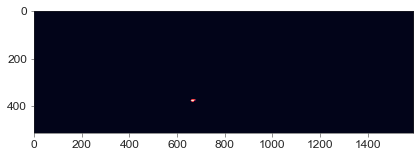

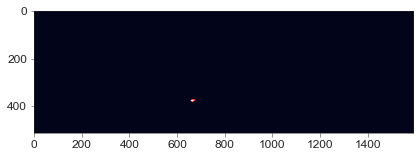

In [194]:
# This is the mask per roi that the alignment algorithm sees
roistack = np.zeros([sess.s2p_stats.shape[0], sess.s2p_ops['Ly'], sess.s2p_ops['Lx']]).astype(np.float32)
for i, roi in enumerate(sess.s2p_stats):
    roistack[i, roi['ypix'], roi['xpix']] = 1
        
roistack2 = np.zeros([sess2.s2p_stats.shape[0], sess2.s2p_ops['Ly'], sess2.s2p_ops['Lx']]).astype(np.float32)
for i, roi in enumerate(sess2.s2p_stats):
    roistack2[i, roi['ypix'], roi['xpix']] = 1
        
plt.figure()
plt.imshow(roistack[roi_match['roi_match_inds'][0][1]['ref_inds'][0],:,:])
plt.figure()
plt.imshow(roistack2[roi_match['roi_match_inds'][0][1]['targ_inds'][0],:,:])

## Get common ROIs for a subset of experiment days

In [211]:
# Output is shape days x cells, limited to cells tracked across all days given
inds_to_match = []

exp_days = [1,2]
for dd in exp_days:
    sess_ind = ut.get_ind_of_exp_day(sessions_dict.single_plane, mouse, dd)
    inds_to_match.append(sess_ind)

common_rois = tpu.roi_matching.common_rois(roi_match['roi_match_inds'],inds_to_match)

In [212]:
common_rois.shape

(2, 712)